# Example of How to intergrate style sheets in NuGridpy

## I just picked a random example plot from matplotlib to test the affect.

In [1]:
import itertools
from collections import OrderedDict
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler


def filled_hist(ax, edges, values, bottoms=None, orientation='v',
                **kwargs):
    """
    Draw a histogram as a stepped patch.

    Extra kwargs are passed through to `fill_between`

    Parameters
    ----------
    ax : Axes
        The axes to plot to

    edges : array
        A length n+1 array giving the left edges of each bin and the
        right edge of the last bin.

    values : array
        A length n array of bin counts or values

    bottoms : scalar or array, optional
        A length n array of the bottom of the bars.  If None, zero is used.

    orientation : {'v', 'h'}
       Orientation of the histogram.  'v' (default) has
       the bars increasing in the positive y-direction.

    Returns
    -------
    ret : PolyCollection
        Artist added to the Axes
    """
    if orientation not in 'hv':
        raise ValueError("orientation must be in {{'h', 'v'}} "
                         "not {o}".format(o=orientation))

    kwargs.setdefault('step', 'post')
    edges = np.asarray(edges)
    values = np.asarray(values)
    if len(edges) - 1 != len(values):
        raise ValueError('Must provide one more bin edge than value not: '
                         'len(edges): {lb} len(values): {lv}'.format(
                             lb=len(edges), lv=len(values)))

    if bottoms is None:
        bottoms = 0
    bottoms = np.broadcast_to(bottoms, values.shape)

    values = np.r_[values, values[-1]]
    bottoms = np.r_[bottoms, bottoms[-1]]
    if orientation == 'h':
        return ax.fill_betweenx(edges, values, bottoms,
                                **kwargs)
    elif orientation == 'v':
        return ax.fill_between(edges, values, bottoms,
                               **kwargs)
    else:
        raise AssertionError("you should never be here")


def stack_hist(ax, stacked_data, sty_cycle, bottoms=None,
               hist_func=None, labels=None,
               plot_func=None, plot_kwargs=None):
    """
    ax : axes.Axes
        The axes to add artists too

    stacked_data : array or Mapping
        A (N, M) shaped array.  The first dimension will be iterated over to
        compute histograms row-wise

    sty_cycle : Cycler or operable of dict
        Style to apply to each set

    bottoms : array, optional
        The initial positions of the bottoms, defaults to 0

    hist_func : callable, optional
        Must have signature `bin_vals, bin_edges = f(data)`.
        `bin_edges` expected to be one longer than `bin_vals`

    labels : list of str, optional
        The label for each set.

        If not given and stacked data is an array defaults to 'default set {n}'

        If stacked_data is a mapping, and labels is None, default to the keys
        (which may come out in a random order).

        If stacked_data is a mapping and labels is given then only
        the columns listed by be plotted.

    plot_func : callable, optional
        Function to call to draw the histogram must have signature:

          ret = plot_func(ax, edges, top, bottoms=bottoms,
                          label=label, **kwargs)

    plot_kwargs : dict, optional
        Any extra kwargs to pass through to the plotting function.  This
        will be the same for all calls to the plotting function and will
        over-ride the values in cycle.

    Returns
    -------
    arts : dict
        Dictionary of artists keyed on their labels
    """
    # deal with default binning function
    if hist_func is None:
        hist_func = np.histogram

    # deal with default plotting function
    if plot_func is None:
        plot_func = filled_hist

    # deal with default
    if plot_kwargs is None:
        plot_kwargs = {}
    try:
        l_keys = stacked_data.keys()
        label_data = True
        if labels is None:
            labels = l_keys

    except AttributeError:
        label_data = False
        if labels is None:
            labels = itertools.repeat(None)

    if label_data:
        loop_iter = enumerate((stacked_data[lab], lab, s)
                              for lab, s in zip(labels, sty_cycle))
    else:
        loop_iter = enumerate(zip(stacked_data, labels, sty_cycle))

    arts = {}
    for j, (data, label, sty) in loop_iter:
        if label is None:
            label = 'dflt set {n}'.format(n=j)
        label = sty.pop('label', label)
        vals, edges = hist_func(data)
        if bottoms is None:
            bottoms = np.zeros_like(vals)
        top = bottoms + vals
        sty.update(plot_kwargs)
        ret = plot_func(ax, edges, top, bottoms=bottoms,
                        label=label, **sty)
        bottoms = top
        arts[label] = ret
    ax.legend(fontsize=10)
    return arts


# set up histogram function to fixed bins
edges = np.linspace(-3, 3, 20, endpoint=True)
hist_func = partial(np.histogram, bins=edges)

# set up style cycles
color_cycle = cycler(facecolor=plt.rcParams['axes.prop_cycle'][:4])
label_cycle = cycler(label=['set {n}'.format(n=n) for n in range(4)])
hatch_cycle = cycler(hatch=['/', '*', '+', '|'])

# Fixing random state for reproducibility
np.random.seed(19680801)

stack_data = np.random.randn(4, 12250)
dict_data = OrderedDict(zip((c['label'] for c in label_cycle), stack_data))


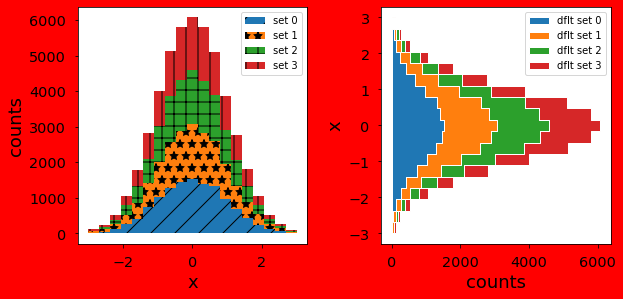

In [3]:
from nugridpy.mesa import set_nice_params
set_nice_params()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
arts = stack_hist(ax1, stack_data, color_cycle + label_cycle + hatch_cycle,
                  hist_func=hist_func);

arts = stack_hist(ax2, stack_data, color_cycle,
                  hist_func=hist_func,
                  plot_kwargs=dict(edgecolor='w', orientation='h'));
ax1.set_ylabel('counts');
ax1.set_xlabel('x');
ax2.set_xlabel('counts');
ax2.set_ylabel('x');


Text(0, 0.5, 'x')

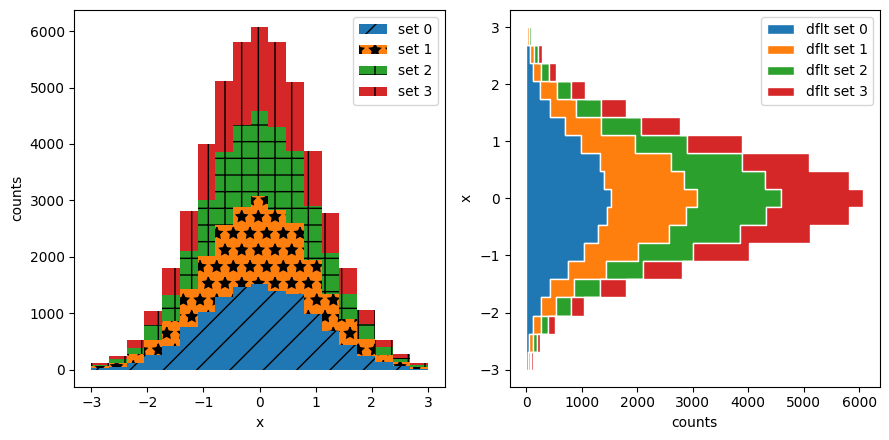

In [4]:
from matplotlib.style import use
use('default')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
arts = stack_hist(ax1, stack_data, color_cycle + label_cycle + hatch_cycle,
                  hist_func=hist_func)

arts = stack_hist(ax2, stack_data, color_cycle,
                  hist_func=hist_func,
                  plot_kwargs=dict(edgecolor='w', orientation='h'))
ax1.set_ylabel('counts')
ax1.set_xlabel('x')
ax2.set_xlabel('counts')
ax2.set_ylabel('x')


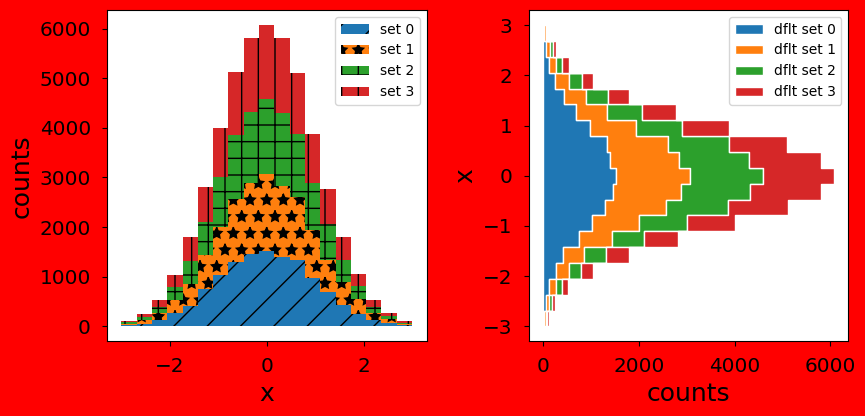

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
arts = stack_hist(ax1, stack_data, color_cycle + label_cycle + hatch_cycle,
                  hist_func=hist_func);

arts = stack_hist(ax2, stack_data, color_cycle,
                  hist_func=hist_func,
                  plot_kwargs=dict(edgecolor='w', orientation='h'));
ax1.set_ylabel('counts');
ax1.set_xlabel('x');
ax2.set_xlabel('counts');
ax2.set_ylabel('x');